In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

## _Classifier Evaluation_

In [7]:
import pytorch_lightning as pl
from LightningModules.GNN.Models.interaction_gnn import InteractionGNN
from LightningModules.GNN.Models.inference import GNNTelemetry, GNNMetrics

### _(+) - Test Dataset_

In [8]:
inputdir="run/gnn_evaluation/test"
testset = sorted(glob.glob(os.path.join(inputdir, "*")))

In [9]:
feature_data = torch.load(testset[0], map_location=device)

In [10]:
feature_data

Data(x=[148, 3], pid=[148], layers=[148], event_file='/global/cscratch1/sd/aakram/train_all/event0000095000', hid=[148], pt=[148], modulewise_true_edges=[2, 139], layerwise_true_edges=[2, 143], edge_index=[2, 961], y_pid=[961], scores=[1922])

### _(+) - Load Model_

- Load model checkpoint
- Load saved config file

In [11]:
ckpnt_path = "run/lightning_models/lightning_checkpoints/GNNStudy/version_1/checkpoints/last.ckpt"

In [12]:
# Model Checkpoint
checkpoint = torch.load(ckpnt_path, map_location=device)

In [13]:
# Checkpointing Hyperparameters
print(checkpoint["hyper_parameters"])

{'input_dir': '/global/cscratch1/sd/aakram/run/feature_store', 'output_dir': '/global/cscratch1/sd/aakram/run/gnn_evaluation', 'project': 'GNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [90000, 5000, 5000], 'noise': False, 'overwrite': True, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 40, 'callbacks': ['GNNTelemetry', 'GNNBuilder'], 'resume_id': 'version_1', 'logger': 'tb', 'model_library': 'LightningModules', 'artifact_library': '/global/cscratch1/sd/aakram/run/lightning_models/lightning_checkpoints', 'set': 'GNN', 'name': 'InteractionGNN', 'config': 'train_quickstart_GNN.yaml', 'batch_config': 'batch_gpu_default.yaml', 'inference

In [14]:
# Get the checkpoint config
config = checkpoint["hyper_parameters"]

In [15]:
# Modified defaults with custom settings
config["checkpoint_path"] = ckpnt_path
config["input_dir"] = "run/feature_store"
config["output_dir"] = "run/gnn_evaluation"
config["artifact_library"] = "lightning_models/lightning_checkpoints"
config["datatype_split"] = [90000, 5000, 5000]
config["callbacks"] = ['GNNTelemetry']
config["map_location"] = device

In [16]:
# Checkpointing Hyperparameters, with Corrections
print(checkpoint["hyper_parameters"])

{'input_dir': 'run/feature_store', 'output_dir': 'run/gnn_evaluation', 'project': 'GNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [90000, 5000, 5000], 'noise': False, 'overwrite': True, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 40, 'callbacks': ['GNNTelemetry'], 'resume_id': 'version_1', 'logger': 'tb', 'model_library': 'LightningModules', 'artifact_library': 'lightning_models/lightning_checkpoints', 'set': 'GNN', 'name': 'InteractionGNN', 'config': 'train_quickstart_GNN.yaml', 'batch_config': 'batch_gpu_default.yaml', 'inference': False, 'checkpoint_path': 'run/lightning_models/lightning_checkpoints/GNNStudy/version_1/checkpoint

In [17]:
# Init the InteractionGNN
model = InteractionGNN(config)

In [18]:
# 'config' has all needed info., just pass it as **kwargs
model = model.load_from_checkpoint(**config)

In [19]:
# Load Trainer
trainer = pl.Trainer(callbacks=[GNNTelemetry(), GNNMetrics()])

/home/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Starting TELEMETRY


/home/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

/home/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


(7836002,) (7836002,)


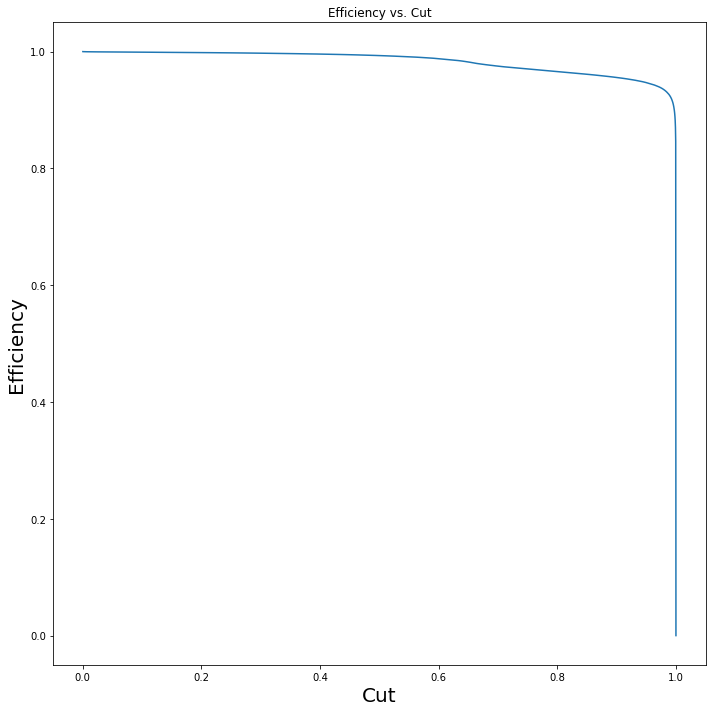

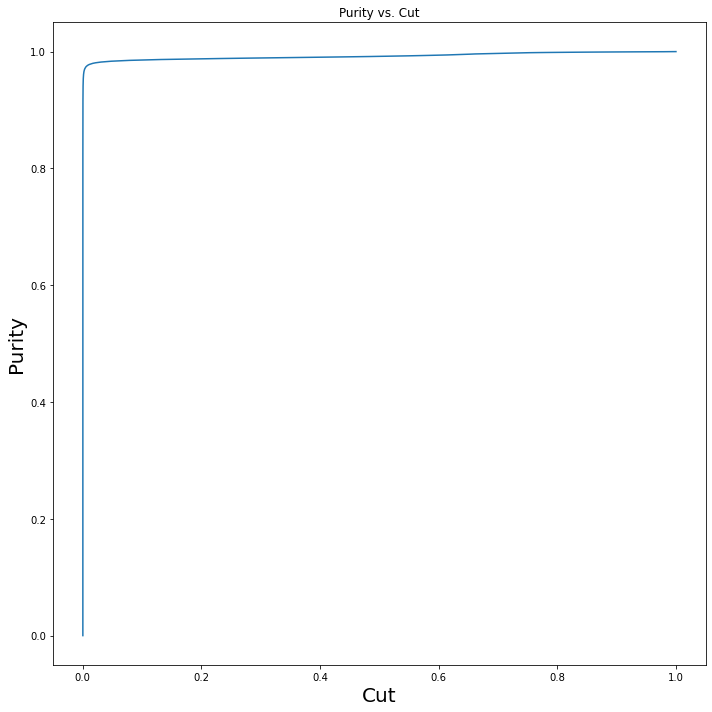

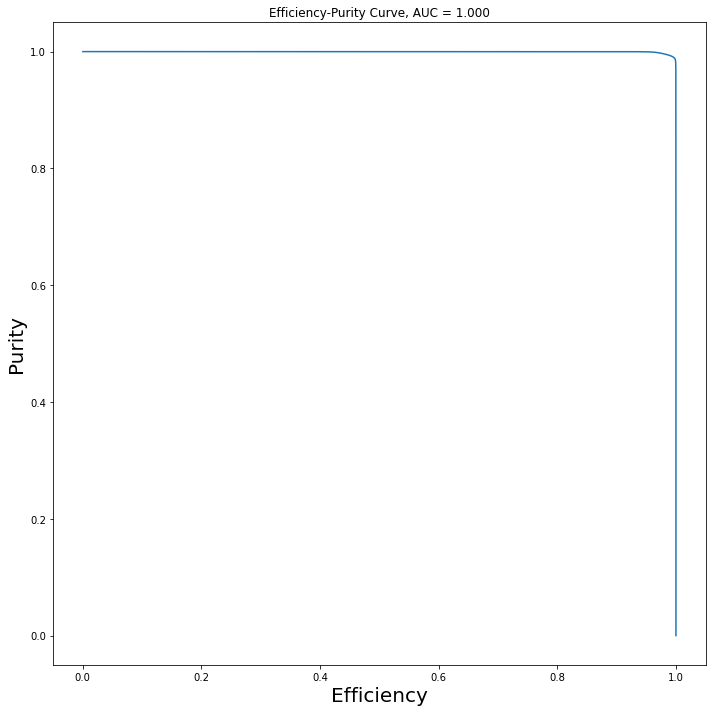

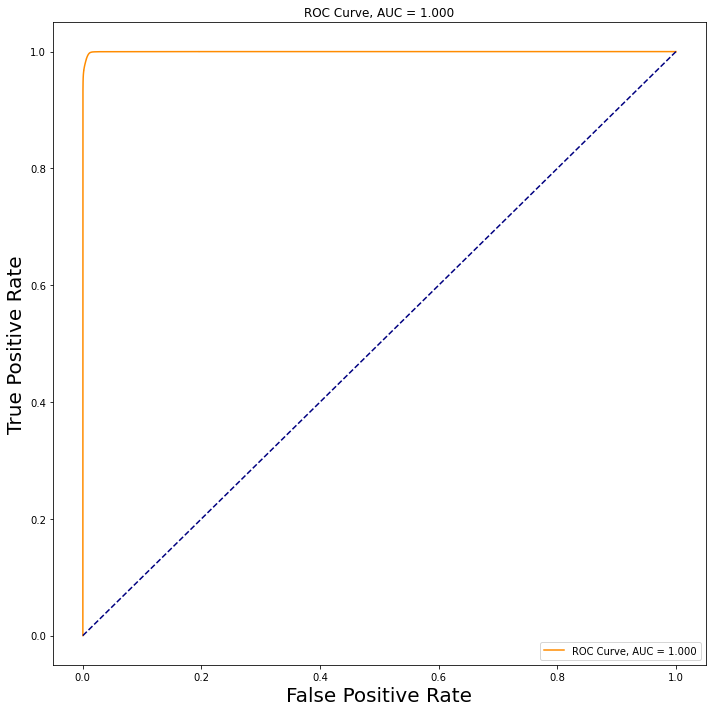

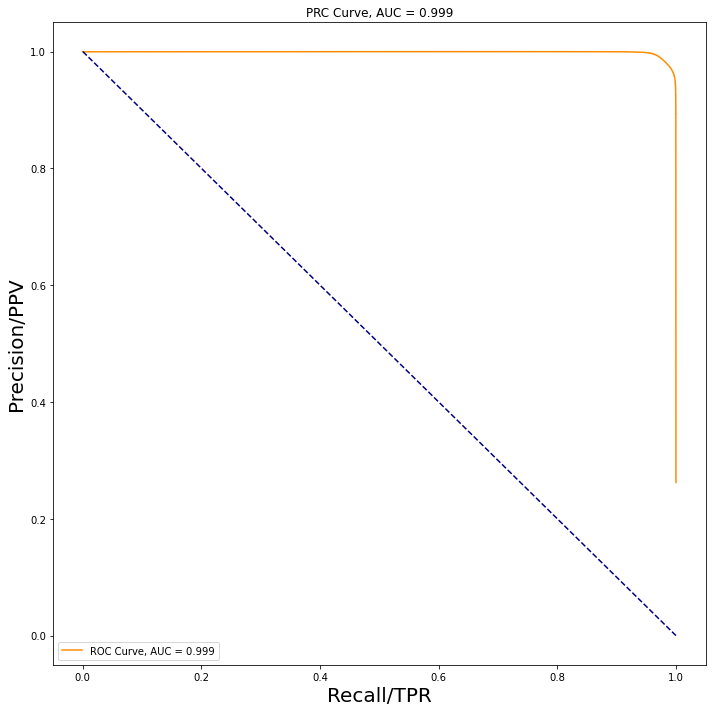

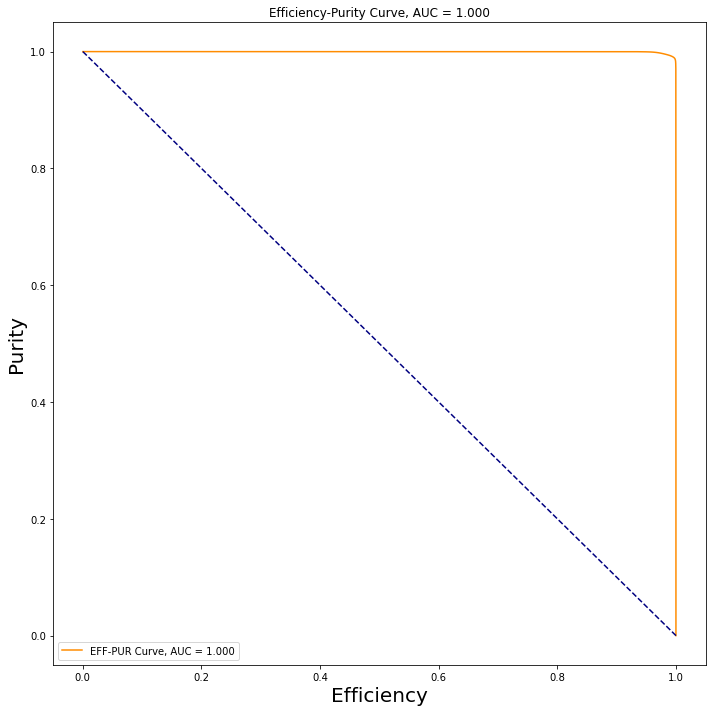

In [20]:
# Test Loop
results = trainer.test(model=model, verbose=True)